In [1]:
from mgwr.gwr import GWR, MGWR
import pandas as pd
import libpysal as ps
import statsmodels.api as sm
import numpy as np
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
from mgwr.diagnostics import corr
from itertools import combinations as combo
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
from geopy.distance import geodesic
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
plt.style.use('ggplot')

# Load Dataframe:

In [2]:
data = pd.read_csv('Data/data_for_gwr.csv')

In [3]:
data.head(3)

,county,yr_month_x,real_price,year,month,population,cases_per_100k,3yr_av_price,av_prop_flats,lockdown,stamp_duty,priv_os_av_size,ann_price_change,long,lat
0,Bath And North East Somerset,2020-01-01,408087.080371,2020,1,193282,0.000000,419871.188521,0.224206,0,0,389.8,0.061941,-2.48654,51.356041
1,Bath And North East Somerset,2020-02-01,368081.624487,2020,2,193282,0.000000,419871.188521,0.224206,0,0,389.8,-0.135711,-2.48654,51.356041
2,Bath And North East Somerset,2020-03-01,392199.964022,2020,3,193282,27.421074,419871.188521,0.224206,0,0,389.8,-0.070570,-2.48654,51.356041


In [4]:
data.shape

(1100, 15)

In [5]:
uk_shape = pd.read_csv('Data/uk_shape_county_cleaned.csv')

# Creating Log Variables:

In [6]:
data['log_price'] = np.log(data['3yr_av_price'])

In [7]:
data['log_pop'] = np.log(data['population'])

In [8]:
data['log_cases'] = np.log1p(data['cases_per_100k'])

In [9]:
data['log_av_size'] = np.log(data['priv_os_av_size'])

In [10]:
data['log_real_price'] = np.log(data['real_price'])

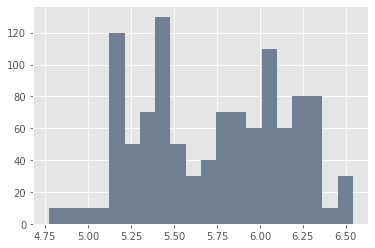

In [11]:
plt.hist(data['log_av_size'], bins =20, color = 'slategrey')

plt.show()

In [12]:
len(data)

1100

In [13]:
data_trial = data[~((data['county']=='Wiltshire') & (data['month']==3))].reset_index(drop=True)

In [14]:
len(data_trial)

1099

In [15]:
data_trial.head()

,county,yr_month_x,real_price,year,month,population,cases_per_100k,3yr_av_price,av_prop_flats,lockdown,stamp_duty,priv_os_av_size,ann_price_change,long,lat,log_price,log_pop,log_cases,log_av_size,log_real_price
0,Bath And North East Somerset,2020-01-01,408087.080371,2020,1,193282,0.000000,419871.188521,0.224206,0,0,389.8,0.061941,-2.48654,51.356041,12.947703,12.171906,0.000000,5.965634,12.919236
1,Bath And North East Somerset,2020-02-01,368081.624487,2020,2,193282,0.000000,419871.188521,0.224206,0,0,389.8,-0.135711,-2.48654,51.356041,12.947703,12.171906,0.000000,5.965634,12.816060
2,Bath And North East Somerset,2020-03-01,392199.964022,2020,3,193282,27.421074,419871.188521,0.224206,0,0,389.8,-0.070570,-2.48654,51.356041,12.947703,12.171906,3.347131,5.965634,12.879527
3,Bath And North East Somerset,2020-04-01,469495.468044,2020,4,193282,103.993129,419871.188521,0.224206,1,0,389.8,0.122327,-2.48654,51.356041,12.947703,12.171906,4.653895,5.965634,13.059414
4,Bath And North East Somerset,2020-05-01,373742.045354,2020,5,193282,39.838164,419871.188521,0.224206,1,0,389.8,-0.046602,-2.48654,51.356041,12.947703,12.171906,3.709617,5.965634,12.831321


In [16]:
last_mo_price = []
last_mo_price.append(1)

for i in range(0, 1098):
    price = data_trial.real_price[i]
    last_mo_price.append(price)

In [17]:
data_trial['last_mo_price'] = last_mo_price

In [18]:
data_trial_wo_jan = data_trial[data_trial['month']!= 1]

In [19]:
len(data_trial_wo_jan)

989

# Defining Feature and Target Variables

In [20]:
X = data_trial_wo_jan[['month', 'log_pop', 'log_cases', 'log_price', 'av_prop_flats', 
                'lockdown', 'stamp_duty', 'priv_os_av_size', 'last_mo_price', 'log_real_price']].values

In [21]:
target_df = data_trial_wo_jan['ann_price_change']

In [22]:
y = target_df.values.reshape((-1, 1))

In [26]:
y

array([[-1.35710551e-01],
       [-7.05695016e-02],
       [ 1.22327082e-01],
       [-4.66016638e-02],
       [-1.36441349e-02],
       [-2.10164730e-02],
       [ 1.16700736e-02],
       [ 1.35656325e-01],
       [-1.22130859e-01],
       [ 3.78845977e-02],
       [-4.27980651e-02],
       [-2.15224942e-02],
       [-2.46160884e-02],
       [-1.06756633e-01],
       [ 7.35701757e-02],
       [ 8.26903644e-03],
       [ 5.51635480e-02],
       [-1.23737018e-02],
       [-5.96490464e-02],
       [ 2.54487992e-02],
       [-1.47254309e-01],
       [-6.53123016e-02],
       [-6.77439393e-02],
       [-4.83253625e-02],
       [-8.27966191e-02],
       [-1.57000286e-01],
       [-1.02708957e-01],
       [-4.14318006e-02],
       [ 5.88779757e-02],
       [-6.86779194e-02],
       [ 4.91072981e-02],
       [-6.34225283e-02],
       [-8.86076167e-02],
       [ 1.31151503e-02],
       [-2.19711163e-03],
       [ 9.98581429e-02],
       [-1.20164899e-01],
       [ 9.12489623e-02],
       [-1.5

In [23]:
# For GWR/MGWR:
coords = list(zip(data_trial_wo_jan.long, data_trial_wo_jan.lat))

# Normalizing / Standardizing the Data:

## Normalizing:

In [383]:
scaler = MinMaxScaler()

In [420]:
n_X = scaler.fit_transform(X)

In [421]:
n_y = scaler.fit_transform(y)

## Standardizing:

In [24]:
s_X = (X - X.mean(axis = 0)) / X.std(axis = 0)

In [25]:
s_y =  (y - y.mean(axis = 0)) / y.std(axis = 0)

# Ordinary Least Squares:

In [649]:
model = sm.OLS(s_y, s_X).fit()

In [650]:
predictions = model.predict(s_X)

In [651]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.709
Model:                            OLS   Adj. R-squared (uncentered):              0.706
Method:                 Least Squares   F-statistic:                              238.2
Date:                Wed, 30 Dec 2020   Prob (F-statistic):                   3.65e-254
Time:                        16:42:19   Log-Likelihood:                         -793.36
No. Observations:                 989   AIC:                                      1607.
Df Residuals:                     979   BIC:                                      1656.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1646      0.054     -3.023      0.003      -0.271      -0.058
x2            -0.0152      0.018     -0.825      0.409      -0.051       0.021
x3             0.0408      0.026      1.565      0.118      -0.010       0.092
x4            -4.3208      0.116    -37.351      0.000      -4.548      -4.094
x5             0.0312      0.031      0.994      0.320      -0.030       0.093
x6            -0.0210      0.027     -0.767      0.443      -0.075       0.033
x7            -0.0042      0.055     -0.078      0.938      -0.111       0.103
x8             0.0380      0.026      1.441      0.150      -0.014       0.090
x9             0.0943      0.059      1.598      0.110      -0.021       0.210
x10            4.5129      0.103     43.933      0.000       4.311       4.715
==============================================================================
Omnibus:                      119.271   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1066.258
Skew:                          -0.096   Prob(JB):                    2.92e-232
Kurtosis:                       8.083   Cond. No.                         16.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

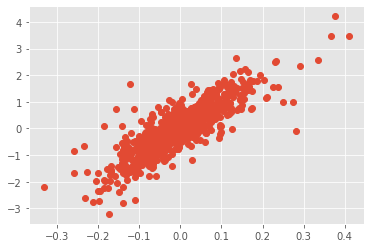

In [652]:
fig, ax = plt.subplots()
ax.plot(y, predictions, 'o', label="Data")

plt.show()

# Multiple Linear Regression:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(s_X, s_y, test_size = 0.3, random_state=9)

In [28]:
lin_reg_mod = linear_model.LinearRegression()

In [29]:
lin_reg_mod.fit(X_train, y_train)

LinearRegression()

In [30]:
pred = lin_reg_mod.predict(X_test)

In [31]:
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))

test_set_r2 = r2_score(y_test, pred)

In [32]:
print(test_set_rmse)
print(test_set_r2)

0.5585756440112504
0.6435526352235701


In [744]:
mlr_df = pd.DataFrame({'pred_y': pred[:, 0], 'y_true': y_test[:,0]})

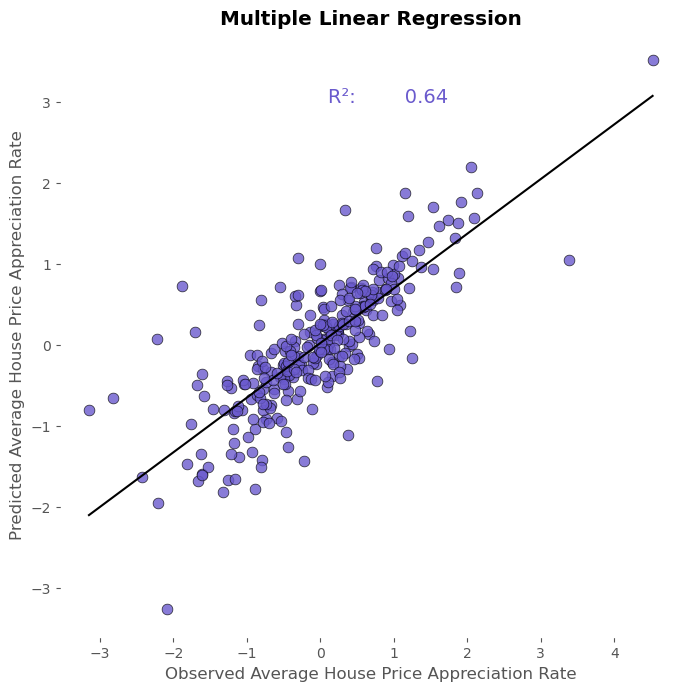

In [1064]:
fig, ax = plt.subplots(figsize = (8,8), dpi=100)
x = mlr_df.y_true
y = mlr_df.pred_y

plt.scatter(x, y, alpha = 0.8, color='slateblue', edgecolor='black', s=60)

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black')
plt.xlabel('Observed Average House Price Appreciation Rate')
plt.ylabel('Predicted Average House Price Appreciation Rate')
plt.grid('off')
plt.title('Multiple Linear Regression', fontweight='bold')

plt.text(0.1, 3, "R²:        0.64", color='slateblue', fontsize = (14))
plt.show()

In [922]:
mlr_df.head()

,pred_y,y_true,resid
0,1.704520,1.535921,-0.168599
1,-1.035287,-0.890010,0.145277
2,0.465285,0.041969,-0.423316
3,-0.138527,-0.304656,-0.166129
4,-0.804834,-3.147248,-2.342415


In [921]:
mlr_df['resid'] = mlr_df['y_true'] - mlr_df['pred_y']

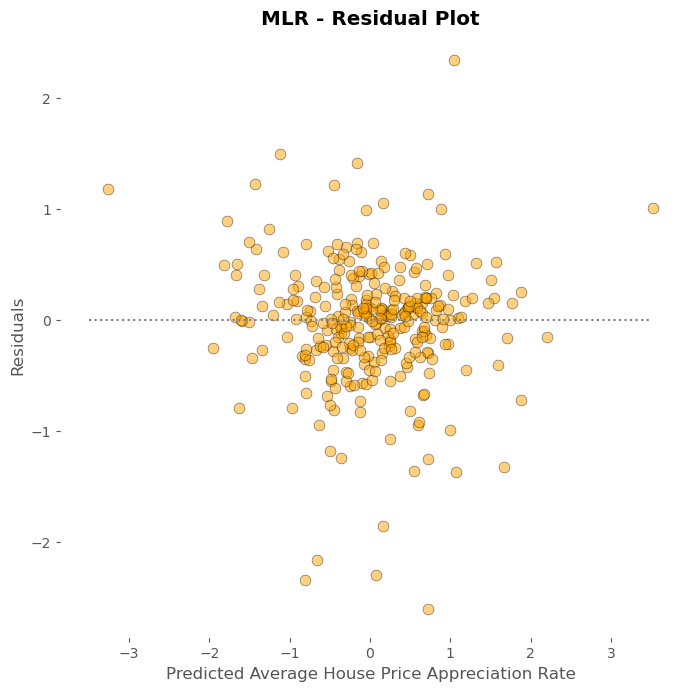

In [929]:
fig, ax = plt.subplots(figsize = (8,8), dpi=100)
x = mlr_df.pred_y
y = mlr_df.resid

plt.scatter(x, y, alpha = 0.5, color='orange', edgecolor='black', s=60)

plt.hlines(0, -3.5, 3.5, linestyle="dotted", color = 'grey')
plt.xlabel('Predicted Average House Price Appreciation Rate')
plt.ylabel('Residuals')
plt.grid('off')
plt.title('MLR - Residual Plot', fontweight='bold')

plt.show()

# GWR and MGWR:

## Bandwidth Selector:

In [26]:
gwr_selector = Sel_BW(coords, s_y, s_X)

In [27]:
gwr_bw = gwr_selector.search()

In [28]:
gwr_bw

635.0

In [29]:
gwr_model = GWR(coords, s_y, s_X, gwr_bw)

In [30]:
gwr_results = gwr_model.fit()

In [31]:
gwr_results.resid_ss

262.2201708216287

In [32]:
gwr_results.aic

1570.979830386784

In [33]:
gwr_results.R2

0.7348633257617506

In [34]:
def all_corr(results,variables):
    """
    Computes  local correlation coefficients (n, (((p+1)**2) + (p+1) / 2) within a geographically
    weighted design matrix
    Returns one array with the order and dimensions listed above where n
    is the number of locations used as calibrations points and p is the
    number of explanatory variables; +1 accounts for the dependent variable.
    Local correlation coefficient is not calculated for constant term.
    """
    #print(self.model)
    x = results.X
    y = results.y
    x = np.column_stack((x,y))
    w = results.W
    nvar = x.shape[1]
    nrow = len(w)
    if results.model.constant:
        ncor = (((nvar - 1)**2 + (nvar - 1)) / 2) - (nvar - 1)
        jk = list(combo(range(1, nvar), 2))
    else:
        ncor = (((nvar)**2 + (nvar)) / 2) - nvar
        jk = list(combo(range(nvar), 2))
    corr_mat = np.ndarray((nrow, int(ncor)),dtype=dict)
    
    for i in range(nrow):
        wi = w[i]
        sw = np.sum(wi)
        wi = wi / sw
        tag = 0

        for j, k in jk:
            val = corr(np.cov(x[:, j], x[:, k], aweights=wi))[0][1] 
            corr_mat[i,tag] = {"var": variables[j-1]+"_"+variables[k-1], "var_1": variables[j-1], "var_2": variables[k-1], "value": val}
            tag = tag + 1
            
    return corr_mat

In [35]:
corr_matrix = all_corr(gwr_results, ['month', 'log_pop', 'log_cases', 'log_price', 'av_prop_flats', 
                'lockdown', 'stamp_duty', 'priv_os_av_size', 'last_mo_price', 'log_real_price', 'ann_price_change'])
#Filter only those correlation coefficients against the Leave vote
corr_2 = [{d['var']: d['value'] for d in x if d['var_2'] == 'ann_price_change'} for x in corr_matrix]
corr_coeffs = pd.DataFrame.from_records(corr_2)

In [36]:
corr_coeffs.head()

,month_ann_price_change,log_pop_ann_price_change,log_cases_ann_price_change,log_price_ann_price_change,av_prop_flats_ann_price_change,lockdown_ann_price_change,stamp_duty_ann_price_change,priv_os_av_size_ann_price_change,last_mo_price_ann_price_change,log_real_price_ann_price_change
0,0.039735,0.083537,-0.197735,0.138623,0.095604,-0.218714,0.142179,0.112781,0.153332,0.2978
1,0.039735,0.083537,-0.197735,0.138623,0.095604,-0.218714,0.142179,0.112781,0.153332,0.2978
2,0.039735,0.083537,-0.197735,0.138623,0.095604,-0.218714,0.142179,0.112781,0.153332,0.2978
3,0.039735,0.083537,-0.197735,0.138623,0.095604,-0.218714,0.142179,0.112781,0.153332,0.2978
4,0.039735,0.083537,-0.197735,0.138623,0.095604,-0.218714,0.142179,0.112781,0.153332,0.2978


In [56]:
len(data_trial_wo_jan)

989

In [69]:
data_trial_wo_jan.to_csv('Data/data_trial_corr.csv')

In [57]:
len(corr_coeffs)

989

In [68]:
corr_coeffs.to_csv('Data/corr_coeffs.csv')

In [42]:
corr_df.to_csv('Data/corr_df.csv')

In [46]:
corr_df_grouped = corr_df.groupby('county')['month_ann_price_change', 'log_pop_ann_price_change', 'log_cases_ann_price_change', 
                          'log_price_ann_price_change', 'av_prop_flats_ann_price_change', 'lockdown_ann_price_change',
                          'stamp_duty_ann_price_change', 'priv_os_av_size_ann_price_change', 
                          'last_mo_price_ann_price_change', 'log_real_price_ann_price_change'].mean().reset_index()

C:\Users\rozhouse\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [47]:
len(corr_df_grouped)

56

In [50]:
corr_df_grouped.tail()

,county,month_ann_price_change,log_pop_ann_price_change,log_cases_ann_price_change,log_price_ann_price_change,av_prop_flats_ann_price_change,lockdown_ann_price_change,stamp_duty_ann_price_change,priv_os_av_size_ann_price_change,last_mo_price_ann_price_change,log_real_price_ann_price_change
51,Medway,0.184103,0.081340,-0.023354,0.164369,0.137195,-0.178804,0.256073,0.074282,0.216702,0.335107
52,Merseyside,0.088330,0.060004,-0.179322,0.187802,0.177299,-0.275820,0.207931,0.150516,0.206330,0.363874
53,Nottingham,0.006532,0.054272,-0.232535,0.161340,0.105957,-0.268551,0.106060,0.129675,0.162571,0.351561
54,Peterborough,0.012696,0.036232,-0.229398,0.163525,0.108577,-0.278555,0.113669,0.137846,0.166016,0.359608
55,Plymouth,0.010352,0.107966,-0.190165,0.243116,0.213090,-0.236624,0.109271,0.169933,0.249499,0.428933


In [49]:
corr_df_grouped.to_csv('Data/corr_df.csv')

In [59]:
corr_df_grouped_merged = pd.merge(corr_df_grouped, uk_shape,  how='left', on=['county'])

In [64]:
len(corr_df_grouped_merged)

99

In [60]:
geo_corr = GeoDataFrame(corr_df_grouped_merged)

In [65]:
len(geo_corr)

99

In [1033]:
data_trial_wo_jan['r2'] = gwr_results.localR2

C:\Users\rozhouse\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1034]:
data_trial_wo_jan.head()

,county,yr_month_x,real_price,year,month,population,cases_per_100k,3yr_av_price,av_prop_flats,lockdown,...,ann_price_change,long,lat,log_price,log_pop,log_cases,log_av_size,log_real_price,last_mo_price,r2
1,Bath And North East Somerset,2020-02-01,368081.624487,2020,2,193282,0.000000,419871.188521,0.224206,0,...,-0.135711,-2.48654,51.356041,12.947703,12.171906,0.000000,5.965634,12.816060,408087.080371,0.68131
2,Bath And North East Somerset,2020-03-01,392199.964022,2020,3,193282,27.421074,419871.188521,0.224206,0,...,-0.070570,-2.48654,51.356041,12.947703,12.171906,3.347131,5.965634,12.879527,368081.624487,0.68131
3,Bath And North East Somerset,2020-04-01,469495.468044,2020,4,193282,103.993129,419871.188521,0.224206,1,...,0.122327,-2.48654,51.356041,12.947703,12.171906,4.653895,5.965634,13.059414,392199.964022,0.68131
4,Bath And North East Somerset,2020-05-01,373742.045354,2020,5,193282,39.838164,419871.188521,0.224206,1,...,-0.046602,-2.48654,51.356041,12.947703,12.171906,3.709617,5.965634,12.831321,469495.468044,0.68131
5,Bath And North East Somerset,2020-06-01,399703.399288,2020,6,193282,4.139030,419871.188521,0.224206,1,...,-0.013644,-2.48654,51.356041,12.947703,12.171906,1.636864,5.965634,12.898478,373742.045354,0.68131


In [1043]:
data_grouped = data_trial_wo_jan.groupby('county')['r2'].mean().reset_index()

In [1053]:
data_grouped.head()

,county,r2
0,Bath And North East Somerset,0.681310
1,Bedford,0.751026
2,Blackburn With Darwen,0.696377
3,Blackpool,0.694420
4,Blaenau Gwent,0.689430


In [1055]:
data_grouped.to_csv('Data/localr2_data.csv', index=False)

## Train/Test Split - GWR

In [774]:
gwr_concat_array = np.concatenate((s_X, coords), axis=1)

In [777]:
gwr_X_train, gwr_X_test, gwr_y_train, gwr_y_test = train_test_split(gwr_concat_array, s_y, test_size = 0.3, random_state=9)

In [856]:
X_train_coords = [tuple(x[-2:]) for x in gwr_X_train]
X_test_coords = np.array([tuple(x[-2:]) for x in gwr_X_test])
X_train_gwr_vals = np.array([list(x[:10]) for x in gwr_X_train])
X_test_gwr_vals = np.array([list(x[:10]) for x in gwr_X_test])

In [847]:
gwr_selector = Sel_BW(X_train_coords, y_train, X_train_gwr_vals)

In [770]:
len(y_train)

692

In [828]:
len(X_train_coords)

692

In [829]:
len(X_train_gwr_vals)

692

In [1002]:
np.random.seed(908)
sample = np.random.choice(range(989), 900)
mask = np.ones_like(s_y, dtype = bool).flatten()
mask[sample] = False

In [1003]:
len(sample)

900

In [1004]:
cal_coords = np.array(coords)[mask]
cal_y = s_y[mask]
cal_X = s_X[mask]

In [1005]:
pred_coords = np.array(coords)[~mask]
pred_y_gwr = s_y[~mask]
pred_X_gwr = s_X[~mask]

In [1006]:
len(cal_coords)

408

In [1007]:
len(pred_coords)

581

In [1008]:
gwr_selector = Sel_BW(cal_coords, cal_y, cal_X)

In [1009]:
gwr_bw = gwr_selector.search(bw_min = 2)

In [1010]:
gwr_bw

326.0

In [1011]:
gwr_model_test = GWR(cal_coords, cal_y, cal_X, gwr_bw)

In [1012]:
gwr_test_results =  gwr_model_test.fit()

In [953]:
pred_results = gwr_model_test.predict(pred_coords, pred_X_gwr)

In [1013]:
gwr_test_results.R2

0.7334065631658842

In [1014]:
predictions_gwr = gwr_test_results.predy

In [1015]:
len(predictions_gwr)

408

In [1017]:
dataset = pd.DataFrame({'pred_y': predictions_gwr[:, 0], 'y_true': cal_y[:,0]})

In [1018]:
dataset

,pred_y,y_true
0,-0.697948,-0.827096
1,0.796514,-1.458732
2,-0.440835,-0.486891
3,-0.061718,-0.264159
4,-0.068956,0.938640
...,...,...
403,-1.225999,-1.251827
404,-0.407976,0.766462
405,-0.610032,-0.317234
406,-0.010713,0.498546


In [1020]:
dataset['resid'] = dataset['y_true'] - dataset['pred_y']

In [906]:
plt.rcParams['axes.facecolor'] = 'white'

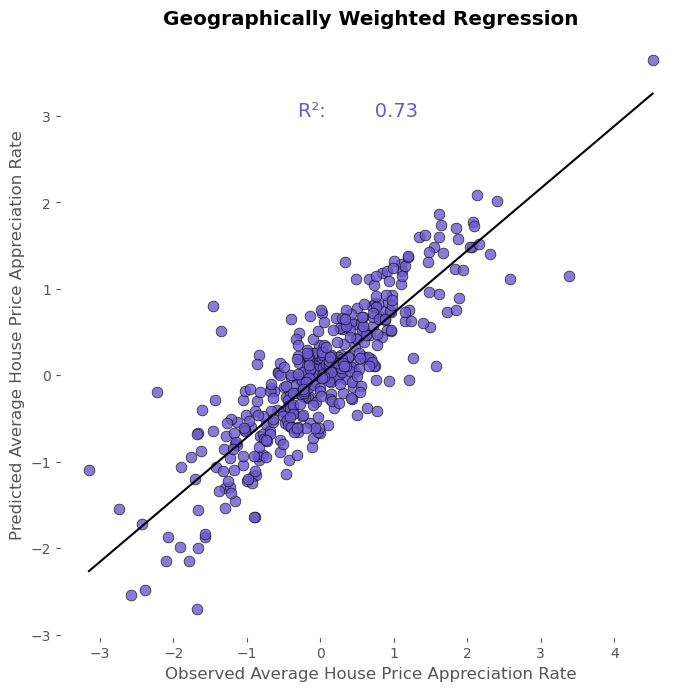

In [1063]:
fig, ax = plt.subplots(figsize = (8,8), dpi =100)
x = dataset.y_true
y = dataset.pred_y

plt.scatter(x, y, alpha = 0.8, color='slateblue', edgecolor='black', s=60)

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black')
plt.xlabel('Observed Average House Price Appreciation Rate')
plt.ylabel('Predicted Average House Price Appreciation Rate')
plt.grid('off')
plt.title('Geographically Weighted Regression',           fontweight='bold')

plt.text(-0.3, 3, "R²:        0.73", color='slateblue', fontsize = (14))
plt.show()

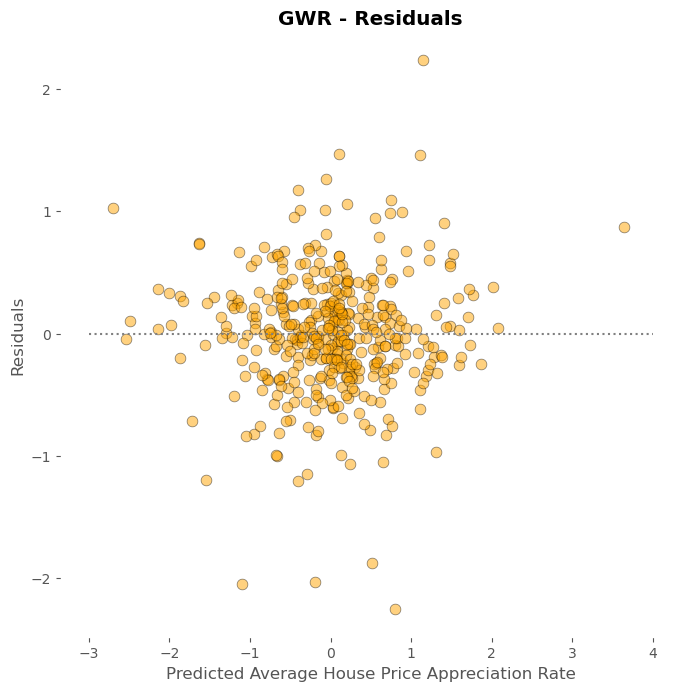

In [1024]:
fig, ax = plt.subplots(figsize = (8,8), dpi =100)
x = dataset.pred_y
y = dataset.resid

plt.scatter(x, y, alpha = 0.5, color='orange', edgecolor='black', s=60)

plt.hlines(0, -3, 4, linestyle="dotted", color = 'grey')
plt.xlabel('Predicted Average House Price Appreciation Rate')
plt.ylabel('Residuals')
plt.grid('off')
plt.title('GWR - Residuals',           fontweight='bold')

plt.show()

In [ ]:
p_vals_100 = gwr_results.spatial_variability(gwr_selector, 100)

In [ ]:
p_vals_1000

# MGWR:

In [661]:
mgwr_selector = Sel_BW(coords, s_y, s_X, multi = True)

In [663]:
mgwr_bw = mgwr_selector.search(multi_bw_min = [500], multi_bw_max = [500])

In [664]:
mgwr_bw

array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.])

In [665]:
mgwr_results = MGWR(coords, s_y, s_X, mgwr_selector).fit()

In [666]:
mgwr_results.R2

0.731259272876882